In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt, IPython.display as ipd, numpy as np
import librosa, librosa.display

/home/violet/projects/wpi/research/MPRL/HRI/librosaTests/venv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/violet/projects/wpi/research/MPRL/HRI/librosaTests/venv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [27]:
y, sr = librosa.load('./audio_samples/480bpm.wav')
ipd.Audio(y, rate=sr)

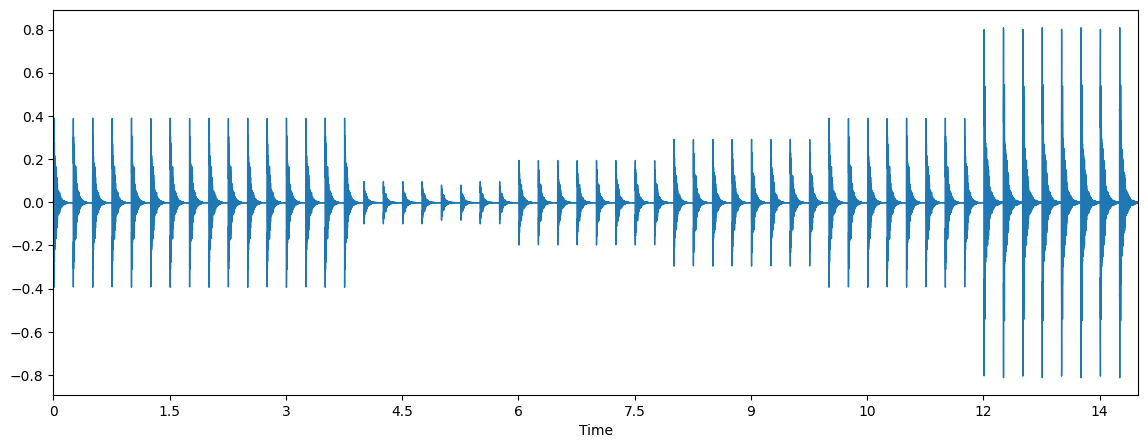

In [28]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

56


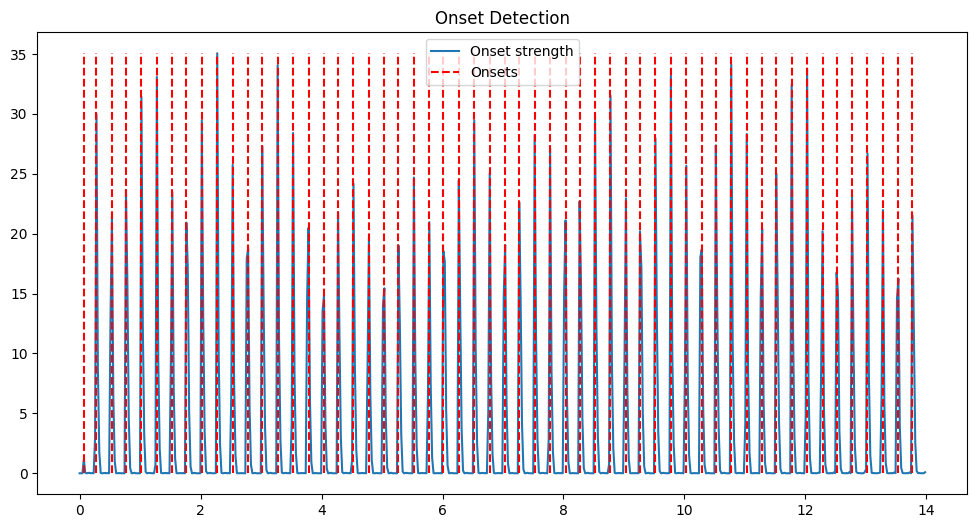

56


In [29]:
onset_envelope = librosa.onset.onset_strength(y, sr=sr)

# Detect onsets using peak picking
onset_frames = librosa.util.peak_pick(onset_envelope, 3, 3, 3, 3, 0.5, 2)

# Convert frame indices to time
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

# Print onset times
print(len(onset_times))

# Visualize the results
times = librosa.times_like(onset_envelope, sr=sr)
plt.figure(figsize=(12, 6))
ax = plt.subplot()
ax.plot(times, onset_envelope, label='Onset strength')
ax.vlines(onset_times, 0, onset_envelope.max(), color='r', linestyle='--', label='Onsets')
ax.legend()
ax.set(title='Onset Detection')
plt.show()

print(len(onset_times))

In [32]:
import math
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np
def array_contains_ish(array, val, deviation_thresh=0.1):
    """
    Should return if array contains a value +-deviation_thresh away from the target.
    
    Asserts that there's a single match, since for our case we want for there to be 
    two points for a single value.
    """
    contains_match = 0
    lower_bound = val - deviation_thresh
    upper_bound = val + deviation_thresh
    for i in array:
        if i > lower_bound and i < upper_bound:
            contains_match += 1
    assert contains_match <= 1, "multiple matches found"
    return contains_match == 1

def score_onsets(detected_onset_times: np.ndarray, bpm):
    
    actual_onset_times = np.arange(0, 14, 60/bpm)
    
    false_positives = len(detected_onset_times) - len(actual_onset_times)
    if (false_positives > 0):
        print(f"{false_positives} false positives")
        for index, i in enumerate(detected_onset_times):
            if (not array_contains_ish(actual_onset_times, i)):
                detected_onset_times = np.delete(detected_onset_times, index)
    elif (false_positives < 0):
        print(f"{abs(false_positives)} missed onsets")
        for index, i in enumerate(actual_onset_times):
            if (not array_contains_ish(detected_onset_times, i)):
                actual_onset_times = np.delete(actual_onset_times, index)
                
    assert len(actual_onset_times) == len(detected_onset_times), f'there was an error in synchronizing array lengths. actual vals had {len(actual_onset_times)} values and detected values had {len(detected_onset_times)} for {bpm} bpm'
    accuracy = np.average(np.subtract(actual_onset_times, detected_onset_times))
    precision = np.std(detected_onset_times)
    
    return accuracy, precision

In [34]:
for i in [120, 240, 480]:
    y, sr = librosa.load(f'./audio_samples/{i}bpm.wav')
    onset_envelope = librosa.onset.onset_strength(y, sr=sr)

    # Detect onsets using peak picking
    onset_frames = librosa.util.peak_pick(onset_envelope, 3, 3, 3, 3, 0.5, 2)

    # Convert frame indices to time
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    
    print(score_onsets(onset_times, i))
    
for i in [120, 240, 480]:
    y, sr = librosa.load(f'./audio_samples/{i}bpm.wav')
    # onset_envelope = librosa.onset.onset_strength(y, sr=sr)

    # Detect onsets using peak picking
    onset_frames = librosa.util.onset(onset_envelope, 3, 3, 3, 3, 0.5, 2)

    # Convert frame indices to time
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    
    print(score_onsets(onset_times, i))

(-0.026909620991253675, 4.034557036416812)
(-0.027131519274376452, 4.039216897676706)
(-0.0421695821185617, 4.039576872527648)
